<a href="https://colab.research.google.com/github/aydawudu/Transformers_Practice/blob/main/Sentiment_Analysis_with_Hugging_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 7.3 MB/s 
     |████████████████████████████████| 7.6 MB 41.0 MB/s 
     |████████████████████████████████| 163 kB 73.4 MB/s 


In [2]:
#Download Data from  https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2022-10-25 14:04:58--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  6.00MB/s    in 0.5s    

2022-10-25 14:04:59 (6.00 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [3]:
#Import Libraries
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
#Demonstrate Basic Usgae of the Hugging Face Pipeline
clf=pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [5]:
type(clf)

transformers.pipelines.text_classification.TextClassificationPipeline

In [6]:
#Let's test out our classifier
clf("This is such as great movie")

[{'label': 'POSITIVE', 'score': 0.9998736381530762}]

In [7]:
clf("This show is dull")

[{'label': 'NEGATIVE', 'score': 0.9998185038566589}]

In [8]:
clf("This show was not interesting")

[{'label': 'NEGATIVE', 'score': 0.9997871518135071}]

In [9]:
clf("This movie is not bad at all")

[{'label': 'POSITIVE', 'score': 0.9993416666984558}]

In [10]:
clf("I can't say this series was interesting")

[{'label': 'NEGATIVE', 'score': 0.9987186193466187}]

In [11]:
#Multiple inputs
clf(["This course is educative.", 
     "I cannot understand the mathematical concepts. I need a PhD to understand the math"])

[{'label': 'POSITIVE', 'score': 0.997118353843689},
 {'label': 'NEGATIVE', 'score': 0.998832643032074}]

In [12]:
import torch

In [13]:
torch.cuda.is_available()

True

In [14]:
torch.cuda.current_device()

0

In [17]:
#Let's use the GPU
clf=pipeline("sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [20]:
#read in our data
df_=pd.read_csv('AirlineTweets.csv')
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [21]:
#copy our interested fields
df=df_[['airline_sentiment', 'text']].copy()

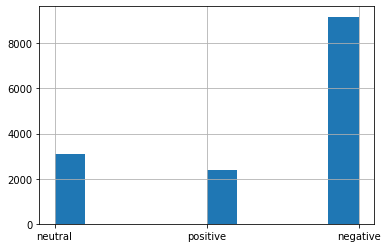

In [22]:
#let's visualize the sentiments
df['airline_sentiment'].hist()

In [25]:
#filter out the rows with nuetral sentiments since our hugging face pipeline is for binary classification
df=df[df.airline_sentiment !='neutral'].copy()

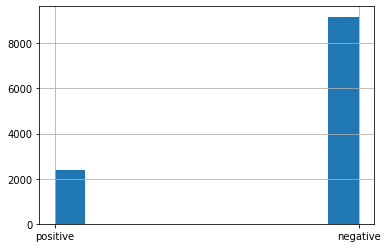

In [26]:
#let views our updated df
df['airline_sentiment'].hist()

We can see that we now have an inbalanced binary dataset

In [27]:
#let map our labels to integers
target_map={'positive':1, 'negative':0}
df['target']=df['airline_sentiment'].map(target_map)

In [28]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [29]:
len(df)

11541

In [32]:
#let use our pretrained clf
%%time 
texts=df['text'].tolist()
predictions=clf(texts)

CPU times: user 1min 10s, sys: 285 ms, total: 1min 10s
Wall time: 1min 15s


In [35]:
#let check out our predictions
predictions[:10]

[{'label': 'POSITIVE', 'score': 0.6070843935012817},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854250550270081},
 {'label': 'POSITIVE', 'score': 0.9553211331367493},
 {'label': 'POSITIVE', 'score': 0.9827088117599487},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408},
 {'label': 'POSITIVE', 'score': 0.9940821528434753},
 {'label': 'POSITIVE', 'score': 0.9863133430480957}]

In [39]:
#since our data is inbalance, we will use auc to evulate the metrics. #1) This requires probabilities of the same kind (have the probabilities be for the positive class)
probs=[dict['score'] if dict['label'].startswith('P') else 1- dict['score'] for dict in predictions]
probs[:10]

[0.6070843935012817,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574944972991943,
 0.9553211331367493,
 0.9827088117599487,
 0.9994851350784302,
 0.9993509650230408,
 0.9940821528434753,
 0.9863133430480957]

In [42]:
#2) convert our prediction into an array where postive=1 and negative = 0
preds=[1 if dict['label'].startswith('P') else 0 for dict in predictions]
preds=np.array(preds)
preds[:10]

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [43]:
#let compute the accuracy
print("accuracy", np.mean(df['target']==preds))

accuracy 0.8898708950697514


The accuracy is high with a score of almost 90%. Howver this is an inbalanced dataset so the accuracy score might be misleading

In [44]:
#let compute the confusion matrix, normialize set to true so that each row sum up to one
cm=confusion_matrix(df['target'], preds, normalize="true")
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

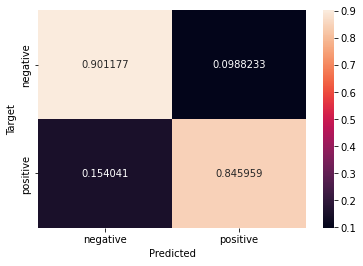

In [46]:
#Let visualize the confusion matrix
def plot_cm(cm):
  classes=['negative', 'positive']
  df_cm=pd.DataFrame(cm, index=classes, columns=classes)
  ax=sns.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel('Target')

plot_cm(cm)

The confusion matrix shows us that we get the higest accuracy in the negative class

In [47]:
#let compute the f1-score, not symmetric
f1_score(df['target'], preds)

0.7587777566900741

In [48]:
f1_score(1-df['target'], 1- preds)

0.928647616908999

In [50]:
#let's compute the auc score
roc_auc_score(df['target'], probs), #not sensitivity to the meaning of the labels

0.9485934229556097

In [51]:
roc_auc_score(1-df['target'], 1- np.array(probs)) #we get the same answer as above since it is symmetric

0.9485934229556096